# CSE 5525 Final Project
- Authors: Steven Broaddus, Tommy Tong

***
***

# Introduction
TODO

***
### SETUP
***

In [18]:
# -*- coding: utf-8 -*-
import re
import json
import logging
import logging.config
import pathlib
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Tuple

import spacy
from keybert import KeyBERT
from pathlib import Path
import sqlite3
import joblib
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import torch
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import QuantileTransformer

from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from transformers import AutoModel, AutoTokenizer
from tqdm.auto import tqdm

from sklearn.preprocessing import StandardScaler
import xgboost as xgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# **** LOCAL IMPORTS ****
from cse5525_final_project.util import (
    load_json_documents,
    combine_dictionaries,
)
from cse5525_final_project.config import (
    LOGGER_CONFIG,
    DB_PATH,
    IMAGES_DIR,
)

# **** LOGGING SETUP ****
logging.config.dictConfig(LOGGER_CONFIG)
logging.getLogger().setLevel(logging.INFO)
logger = logging.getLogger(__name__)

# ---------------------------------
# Load in data
# ---------------------------------
def load_metric_with_prompts(
    db_path: Path,
    metric_table_name: str,
    value_col: str = "value"
) -> pd.DataFrame:
    """
    Load a single metric table and combine with prompts from JSON files.

    Args:
        db_path (Path): Path to the SQLite database.
        metric_table_name (str): Name of the table with UUIDs and metric values.
        value_col (str): Name of the column containing the metric values (default: 'value').

    Returns:
        pd.DataFrame: DataFrame with columns 'uuid', 'prompt', and the metric.
    """
    if not db_path.exists():
        raise FileNotFoundError(f"Database not found at {db_path}")

    # Load JSON prompt data
    json_docs = load_json_documents(IMAGES_DIR)
    if not json_docs:
        raise FileNotFoundError(f"No JSON files found in {IMAGES_DIR}")
    combined_dict = combine_dictionaries(json_docs)

    # Load the metric table
    query = f"SELECT uuid, {value_col} FROM {metric_table_name}"
    with sqlite3.connect(db_path) as conn:
        df_metric = pd.read_sql_query(query, conn)

    # Add prompts based on uuid
    df_metric["prompt"] = df_metric["uuid"].apply(
        lambda u: combined_dict.get(f"{u}.png", {}).get("p", None)
    )

    # Optional: drop rows with missing prompts
    df_metric.dropna(subset=["prompt"], inplace=True)

    return df_metric


# df = load_table_to_dataframe(DB_PATH, "iqa_brisque_metrics")
df = load_metric_with_prompts(
    DB_PATH, "iqa_brisque_metrics", value_col="value"
)

# Drop UUID column as it's not needed for the analysis
df.drop(columns=["uuid"], inplace=True)


In [19]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

def count_modifiers_and_entities(prompt: str) -> Dict[str, Any]:
    doc = nlp(prompt)
    adjectives = [token.text for token in doc if token.pos_ == "ADJ"]
    named_entities = [ent.text for ent in doc.ents]

    return {
        'num_adjectives': len(adjectives),
        'num_named_entities': len(named_entities),
        # 'adjectives': adjectives,
        # 'named_entities': named_entities,
    }

def calculate_complexity(prompt: str) -> Dict[str, Any]:
    words = re.findall(r'\b\w+\b', prompt)
    word_count = len(words)
    unique_word_count = len(set(words))
    comma_count = prompt.count(',')

    complexity_score = (
        0.3 * word_count +
        0.5 * unique_word_count +
        0.2 * comma_count
    )

    return {
        'word_count': word_count,
        'unique_word_count': unique_word_count,
        'comma_count': comma_count,
        'complexity_score': round(complexity_score, 2)
    }

def add_prompt_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds prompt-derived features to the given DataFrame.
    Assumes a 'prompt' column exists.

    Args:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        pd.DataFrame: DataFrame with additional columns for prompt features.
    """
    logging.info("Extracting prompt features...")

    # Extract complexity features
    complexity_features = df["prompt"].apply(calculate_complexity).apply(pd.Series)

    # Extract modifier/entity features
    modifier_features = df["prompt"].apply(count_modifiers_and_entities).apply(pd.Series)

    # Combine into original dataframe
    df = pd.concat([df, complexity_features, modifier_features], axis=1)
    return df

df = add_prompt_features(df)

[INFO][add_prompt_features] | Extracting prompt features...


In [20]:
# Print info about the loaded DataFrame
print("DataFrame Info:")
print(df.info())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   value               1604 non-null   float64
 1   prompt              1604 non-null   object 
 2   word_count          1604 non-null   float64
 3   unique_word_count   1604 non-null   float64
 4   comma_count         1604 non-null   float64
 5   complexity_score    1604 non-null   float64
 6   num_adjectives      1604 non-null   int64  
 7   num_named_entities  1604 non-null   int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 100.4+ KB
None


In [21]:
# Print the first few rows of the DataFrame
print(df.head())

       value                                             prompt  word_count  \
0  -2.711731  a full body high detail fantasy portrait oil p...        54.0   
1   7.618347  concept art of elite scientist by jama jurabae...        21.0   
2  -0.258118  head and torso studio portrait photograph of a...        23.0   
3  15.084656  scene from the 1 9 9 4 science fiction film dune         11.0   
4  19.923035  tall castle enclosed palisaded, with christian...        30.0   

   unique_word_count  comma_count  complexity_score  num_adjectives  \
0               45.0         12.0              41.1              13   
1               21.0          7.0              18.2               3   
2               23.0          7.0              19.8               4   
3               10.0          0.0               8.3               0   
4               29.0         11.0              25.7               9   

   num_named_entities  
0                   3  
1                   1  
2                   2  
3 

***
### DATA PREPROCESSING
***

In [22]:
# ---------------------------------
# Identify and remove duplicates
# ---------------------------------
def remove_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove duplicate rows from a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame to remove duplicates from.

    Returns:
        pd.DataFrame: DataFrame with duplicates removed.
    """
    initial_shape = df.shape
    df = df.drop_duplicates()
    final_shape = df.shape
    logger.info(f"Removed {initial_shape[0] - final_shape[0]} duplicates")
    return df

df = remove_duplicates(df)

[INFO][remove_duplicates] | Removed 0 duplicates


In [23]:
# ---------------------------------
# Identify missing values
# ---------------------------------
# Identify missing values
print("Missing values in Inspection DataFrame:")
missing_values = df.isnull().sum()
print(df.isnull().sum())
if missing_values.sum() > 0:
    raise ValueError("DataFrame contains missing values. Please handle them before proceeding.")

Missing values in Inspection DataFrame:
value                 0
prompt                0
word_count            0
unique_word_count     0
comma_count           0
complexity_score      0
num_adjectives        0
num_named_entities    0
dtype: int64


In [24]:
# ---------------------------------
# Handle outliers
# ---------------------------------
def detect_outliers_iqr(series: pd.Series) -> pd.Series:
    """Detect outliers using the IQR method."""
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (series < lower_bound) | (series > upper_bound)


def detect_spike_at_cap(series: pd.Series, cap_value: float, threshold_ratio: float = 0.01) -> bool:
    """
    Detects if capping caused a spike at the upper bound.
    """
    total = len(series)
    spike_count = (series == cap_value).sum()
    spike_ratio = spike_count / total
    return spike_ratio > threshold_ratio


def choose_imputation_strategy(series: pd.Series, outlier_mask: pd.Series) -> Tuple[str, Optional[float]]:
    """
    Choose best imputation strategy based on skewness and outlier %.
    """
    skewness = series.skew()
    outlier_ratio = outlier_mask.sum() / len(series)

    logger.info(f"{series.name} - Skew: {skewness:.2f}, Outlier ratio: {outlier_ratio:.2%}")

    if outlier_ratio < 0.01:
        return "none", None
    elif outlier_ratio < 0.05:
        return "cap", None
    elif abs(skewness) > 1:
        return "median", series.median()
    else:
        return "mean", series.mean()


def handle_outliers_and_impute(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """
    Systematically handle outliers and correct capping-induced spikes.
    """
    df_result = df.copy()

    for col in columns:
        if df_result[col].dtype.kind not in 'biufc':
            continue

        series = df_result[col]
        outlier_mask = detect_outliers_iqr(series)
        strategy, value = choose_imputation_strategy(series, outlier_mask)

        if strategy == "cap":
            q1 = series.quantile(0.25)
            q3 = series.quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr

            capped = series.clip(lower=lower_bound, upper=upper_bound)

            if detect_spike_at_cap(capped, upper_bound):
                # Spike detected, switch to imputation instead
                value = series.median() if abs(series.skew()) > 1 else series.mean()
                df_result.loc[outlier_mask, col] = value
                logger.info(f"{col}: Spike at cap detected, switched to {('median' if abs(series.skew()) > 1 else 'mean')} imputation")
            else:
                df_result[col] = capped
                logger.info(f"{col}: Capped to IQR bounds")
        elif strategy in {"mean", "median"}:
            df_result.loc[outlier_mask, col] = value
            logger.info(f"{col}: Imputed {outlier_mask.sum()} outliers with {strategy} = {value:.2f}")
        elif strategy == "none":
            logger.info(f"{col}: No action taken")
        else:
            logger.warning(f"{col}: Unknown strategy {strategy}")

    return df_result

df = handle_outliers_and_impute(df, df.columns.tolist())

[INFO][choose_imputation_strategy] | value - Skew: 2.83, Outlier ratio: 4.36%
[INFO][handle_outliers_and_impute] | value: Spike at cap detected, switched to mean imputation
[INFO][choose_imputation_strategy] | word_count - Skew: 0.61, Outlier ratio: 0.50%
[INFO][handle_outliers_and_impute] | word_count: No action taken
[INFO][choose_imputation_strategy] | unique_word_count - Skew: 0.27, Outlier ratio: 0.00%
[INFO][handle_outliers_and_impute] | unique_word_count: No action taken
[INFO][choose_imputation_strategy] | comma_count - Skew: 1.34, Outlier ratio: 3.80%
[INFO][handle_outliers_and_impute] | comma_count: Spike at cap detected, switched to median imputation
[INFO][choose_imputation_strategy] | complexity_score - Skew: 0.41, Outlier ratio: 0.19%
[INFO][handle_outliers_and_impute] | complexity_score: No action taken
[INFO][choose_imputation_strategy] | num_adjectives - Skew: 0.92, Outlier ratio: 0.50%
[INFO][handle_outliers_and_impute] | num_adjectives: No action taken
[INFO][choose_

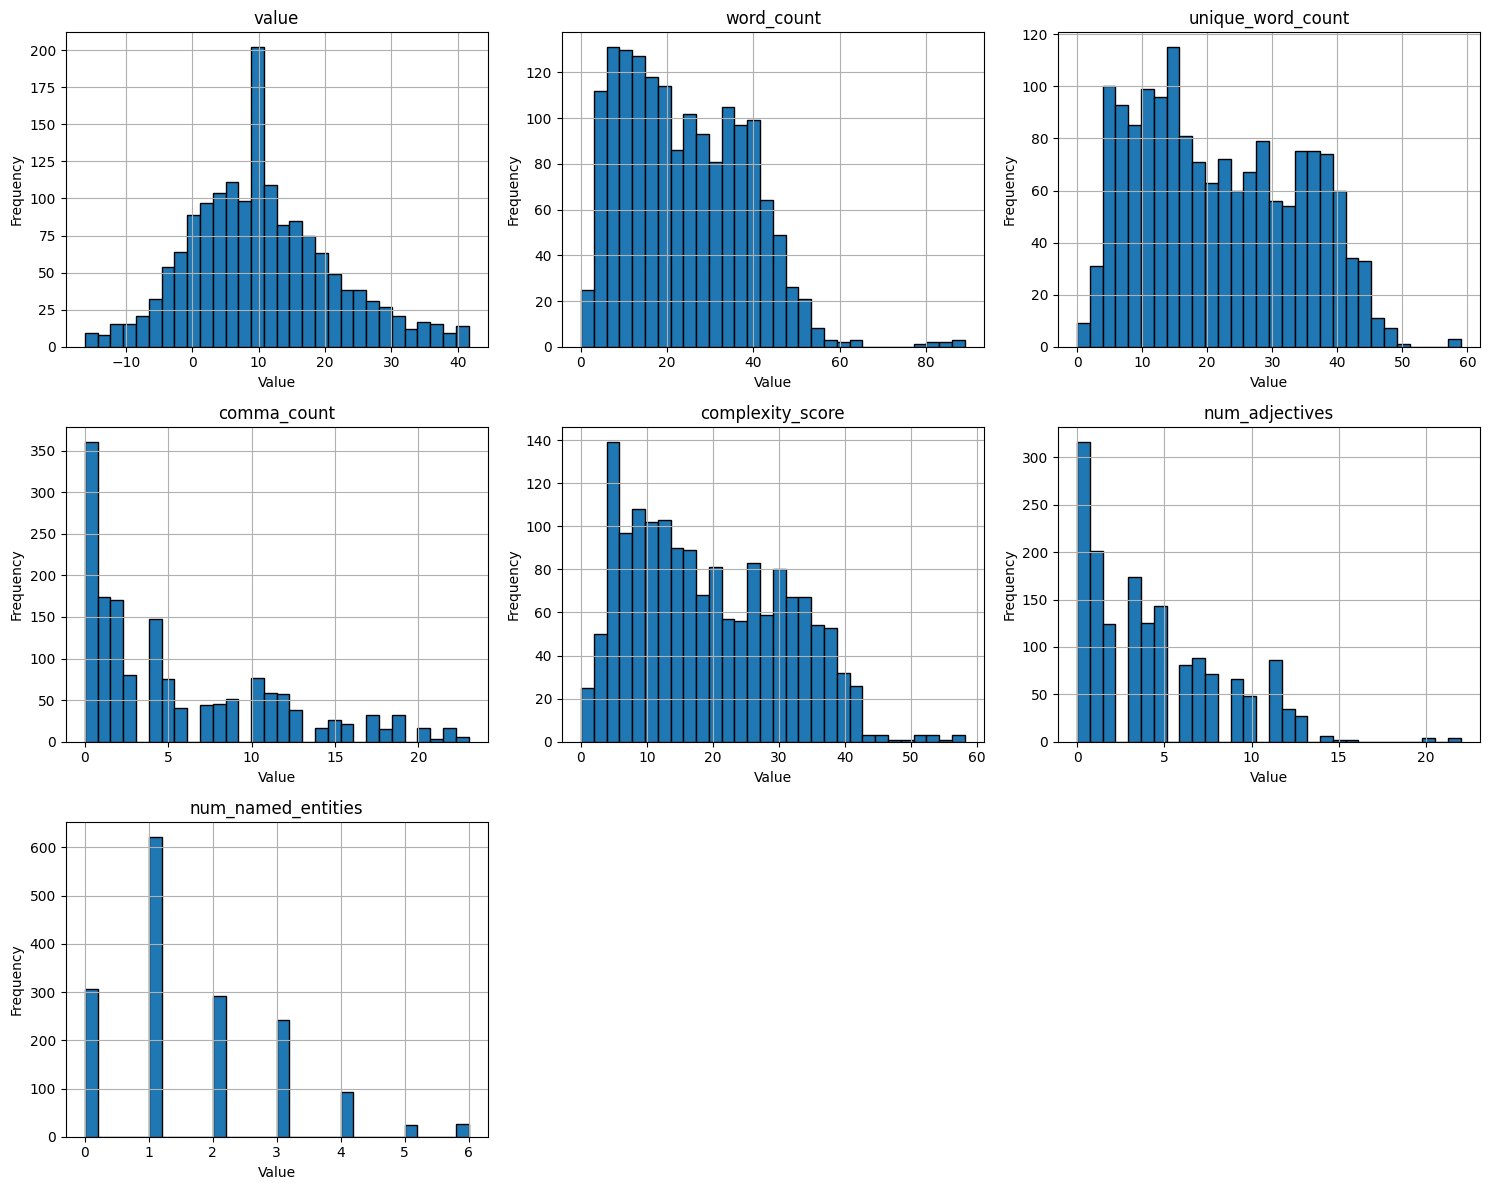

In [25]:
# ---------------------------------
# Plot numerical distributions
# ---------------------------------
def plot_numerical_distributions(df: pd.DataFrame, cols_per_row: int = 3) -> None:
    """
    Plot histograms for all numerical columns in the given DataFrame using subplots.

    Args:
        df (pd.DataFrame): The input DataFrame with numerical columns.
        cols_per_row (int): Number of subplots per row.
    """
    numeric_cols: List[str] = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    num_cols: int = len(numeric_cols)
    num_rows: int = -(-num_cols // cols_per_row)  # Ceiling division

    fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(cols_per_row * 5, num_rows * 4))
    axes = axes.flatten()

    for idx, col in enumerate(numeric_cols):
        ax = axes[idx]
        ax.hist(df[col], bins=30, edgecolor='black')
        ax.set_title(f"{col}")
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")
        ax.grid(True)

    # Hide any unused subplots
    for idx in range(num_cols, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()
        
plot_numerical_distributions(df)


In [26]:
# ---------------------------------
# Drop constant columns
# ---------------------------------
def drop_constant_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Logs and drops constant columns from the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to inspect and modify.

    Returns:
        pd.DataFrame: A copy of the DataFrame with constant columns removed.
    """
    constant_cols = [col for col in df.columns if df[col].nunique(dropna=False) == 1]
    logger.info(f"Found {len(constant_cols)} constant column(s).")
    if constant_cols:
        logger.info(f"Dropping constant columns: {constant_cols}")
    return df.drop(columns=constant_cols)

df = drop_constant_columns(df)

[INFO][drop_constant_columns] | Found 0 constant column(s).


In [27]:
# ---------------------------------
# Scale numerical features
# ---------------------------------
def scale_continuous_columns(
    df: pd.DataFrame, blacklist: Optional[List[str]] = None
) -> pd.DataFrame:
    """Scales continuous numerical columns in the DataFrame using StandardScaler,
    excluding any columns specified in the blacklist.

    Args:
        df (pd.DataFrame): The input DataFrame with numerical features.
        blacklist (Optional[List[str]]): List of column names to exclude from scaling (e.g., encoded categorical codes).

    Returns:
        pd.DataFrame: A copy of the DataFrame with scaled continuous columns.
    """
    # Select numeric columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Identify binary columns (likely already normalized or categorical)
    binary_cols = [col for col in numeric_cols if df[col].nunique() == 2]

    # Define continuous columns as numeric, non-binary, and not blacklisted
    if blacklist is None:
        blacklist = []
    continuous_cols = [
        col for col in numeric_cols
        if col not in binary_cols and col not in blacklist
    ]

    # Apply scaling
    scaler = StandardScaler()
    df_scaled = df.copy()
    df_scaled[continuous_cols] = scaler.fit_transform(df[continuous_cols])
    logger.info(f"Scaled continuous columns: {continuous_cols}")

    return df_scaled

df = scale_continuous_columns(df)

[INFO][scale_continuous_columns] | Scaled continuous columns: ['value', 'word_count', 'unique_word_count', 'comma_count', 'complexity_score', 'num_adjectives', 'num_named_entities']


In [28]:
# ---------------------------------
# Drop sparse binary columns
# ---------------------------------
def drop_sparse_binary_columns(df: pd.DataFrame, sparse_threshold: float = 0.01) -> pd.DataFrame:
    """
    Drop binary columns with low or high presence of 1s.

    Args:
        df (pd.DataFrame): Input DataFrame.
        sparse_threshold (float): Threshold to consider a binary column sparse.

    Returns:
        pd.DataFrame: Modified DataFrame with sparse binary columns dropped.
    """
    cols_to_drop = []
    for col in df.columns:
        if df[col].nunique() == 2:
            p = df[col].mean()
            if p < sparse_threshold or p > 1 - sparse_threshold:
                cols_to_drop.append(col)

    logger.info(f"Dropping sparse binary columns: {cols_to_drop}")
    df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
    return df

df = drop_sparse_binary_columns(df, sparse_threshold=0.01)

[INFO][drop_sparse_binary_columns] | Dropping sparse binary columns: []


In [29]:
# ---------------------------------
# Drop leaky columns
# ---------------------------------
def drop_leaky_columns(df: pd.DataFrame, target: pd.Series, correlation_threshold: float = 0.98) -> pd.DataFrame:
    """
    Drop columns that are highly correlated with the target (excluding the target itself).

    Args:
        df (pd.DataFrame): Input DataFrame.
        target (pd.Series): Target variable.
        correlation_threshold (float): Correlation threshold for leakage.

    Returns:
        pd.DataFrame: Modified DataFrame with leaky columns dropped.
    """
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlations = df[numeric_cols].corrwith(target).abs()
    leaky_cols = correlations[(correlations > correlation_threshold) & (correlations.index != target.name)].index.tolist()

    logger.info(f"Dropping leaky columns: {leaky_cols}")
    df.drop(columns=leaky_cols, inplace=True, errors='ignore')
    return df

df = drop_leaky_columns(df, df["value"], correlation_threshold=0.98)

[INFO][drop_leaky_columns] | Dropping leaky columns: []


In [30]:
# ---------------------------------
# Collapse rare ohe columns
# ---------------------------------
def collapse_rare_one_hot_columns(df: pd.DataFrame, sparse_threshold: float = 0.01) -> pd.DataFrame:
    """
    Collapse rare one-hot columns into a single 'category_other' column.

    Args:
        df (pd.DataFrame): Input DataFrame.
        sparse_threshold (float): Minimum frequency to be considered common.

    Returns:
        pd.DataFrame: Modified DataFrame with rare one-hot columns collapsed.
    """
    from collections import defaultdict

    ohe_candidates = [
        col for col in df.columns if df[col].nunique() == 2 and df[col].max() == 1 and df[col].min() == 0
    ]

    # Group by prefix
    groups = defaultdict(list)
    for col in ohe_candidates:
        parts = col.split("_")
        if len(parts) >= 2:
            prefix = "_".join(parts[:-1])
            groups[prefix].append(col)

    for group_cols in groups.values():
        col_sums = df[group_cols].sum()
        rare_cols = col_sums[col_sums < sparse_threshold * len(df)].index.tolist()

        if rare_cols:
            existing = [col for col in rare_cols if col in df.columns]
            if existing:
                logger.info(f"Collapsing rare one-hot columns into 'category_other': {existing}")
                df["category_other"] = df.get("category_other", 0) + df[existing].sum(axis=1).clip(upper=1)
                df.drop(columns=existing, inplace=True)

    return df

df = collapse_rare_one_hot_columns(df, sparse_threshold=0.01)

In [31]:
# ---------------------------------
# Handle skewness
# ---------------------------------
def apply_quantile_transform_to_skewed(
    df: pd.DataFrame,
    skew_threshold: float = 1.0
) -> pd.DataFrame:
    """
    Apply QuantileTransformer to skewed numerical columns.

    Args:
        df (pd.DataFrame): Input dataframe.
        skew_threshold (float): Absolute skewness above which transformation is applied.

    Returns:
        pd.DataFrame: Transformed dataframe with quantile normalization applied to skewed columns.
    """
    df_transformed = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    transformed_cols = []

    for col in numeric_cols:
        skew = df[col].skew()
        logger.debug(f"Skewness for column '{col}': {skew:.2f}")
        if abs(skew) > skew_threshold:
            qt = QuantileTransformer(output_distribution="normal", random_state=42)
            df_transformed[col] = qt.fit_transform(df[[col]])
            transformed_cols.append(col)
            logger.info(f"Applied QuantileTransformer to skewed column: '{col}' (skewness = {skew:.2f})")

    if not transformed_cols:
        logger.info("No columns exceeded skew threshold. No quantile transformation applied.")

    return df_transformed

df = apply_quantile_transform_to_skewed(df, skew_threshold=1.0)

[INFO][apply_quantile_transform_to_skewed] | Applied QuantileTransformer to skewed column: 'comma_count' (skewness = 1.04)


***
### TRAIN PREDICTION MODELS
***

In [32]:
###############################################################################
#                             BERT EMBEDDER                                   #
###############################################################################
class BertCLSEmbedder:
    """Lightweight util to obtain 768‑D [CLS] embeddings from a BERT model.

    This class is *not* an sklearn transformer to avoid heavy pickling
    overhead; instead, embedding is done inside a FunctionTransformer wrapper
    in the pipeline.

    Attributes
    ----------
    model_name : str
        HuggingFace checkpoint to load.
    max_len : int
        Maximum token length (padding / truncation).
    device : str
        `'cuda'` if available else `'cpu'`.
    """

    def __init__(
        self,
        model_name: str = "bert-base-uncased",
        max_len: int = 64,
        device: Optional[str] = None,
    ) -> None:
        self.model_name = model_name
        self.max_len = max_len
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self._tokenizer: Optional[AutoTokenizer] = None
        self._model: Optional[AutoModel] = None

    # --------------------------- internals -------------------------------- #

    def _lazy_load(self) -> None:
        if self._tokenizer is None or self._model is None:
            logger.info("Loading BERT (%s) on %s", self.model_name, self.device)
            self._tokenizer = AutoTokenizer.from_pretrained(self.model_name)
            self._model = AutoModel.from_pretrained(self.model_name)
            self._model.to(self.device)
            self._model.eval()

    # --------------------------- public API ------------------------------- #

    def __call__(self, prompts: pd.Series) -> np.ndarray:
        """Vectorise a batch of prompts into CLS embeddings."""
        self._lazy_load()
        assert self._tokenizer and self._model
        batch_size = 32
        all_vecs: List[np.ndarray] = []

        for i in tqdm(
            range(0, len(prompts), batch_size), desc="Embedding prompts"
        ):
            batch = prompts.iloc[i : i + batch_size].tolist()
            enc = self._tokenizer(
                batch,
                padding="max_length",
                truncation=True,
                max_length=self.max_len,
                return_tensors="pt",
            ).to(self.device)
            with torch.inference_mode():
                out = self._model(**enc).last_hidden_state[:, 0, :].cpu().numpy()
            all_vecs.append(out)

        return np.vstack(all_vecs)


###############################################################################
#                          BASE PIPELINE RUNNER                               #
###############################################################################
class BasePipelineRunner:
    """
    Base class for pipeline model runners. Subclasses set self.param_grid
    and implement _build_pipeline to return a Pipeline object.
    """

    def __init__(self):
        self.logger = logging.getLogger(__name__)
        self.param_grid: Dict[str, Any] = {}
        self._best_estimator = None

    def _build_pipeline(self) -> Pipeline:
        raise NotImplementedError("Subclasses must implement _build_pipeline.")

    def fit(
        self,
        X_train: pd.DataFrame,
        X_test: pd.DataFrame,
        y_train: pd.Series,
        y_test: pd.Series
    ) -> Dict[str, Any]:
        """
        Fits a GridSearchCV using the pipeline and self.param_grid,
        then evaluates on the test set.
        """
        from sklearn.model_selection import GridSearchCV, KFold
        from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

        self.logger.info("Fitting pipeline with GridSearchCV.")
        pipeline = self._build_pipeline()

        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=self.param_grid,
            scoring="neg_mean_squared_error",
            cv=cv,
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)

        self._best_estimator = grid_search.best_estimator_
        self.logger.info("Best Params: %s", grid_search.best_params_)

        y_pred = self._best_estimator.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        return {
            "best_estimator": self._best_estimator,
            "y_true": y_test,
            "y_pred": y_pred,
            "mse": mse,
            "mae": mae,
            "r2": r2
        }
        
###############################################################################
#                     ANN (MLP) PIPELINE RUNNER                               #
###############################################################################
class ANNPipelineRunner(BasePipelineRunner):
    """
    Pipeline runner for an ANN (MLPRegressor) with no preprocessing step.
    Assumes input DataFrame is already preprocessed.
    """

    def __init__(self):
        super().__init__()
        self.param_grid = {
            "model__hidden_layer_sizes": [(64, 64)],
            "model__activation": ["relu"],
            "model__solver": ["adam"],
            "model__alpha": [0.0001, 0.001, 0.00001],
            "model__learning_rate": ["constant", "adaptive"]
        }

    def _build_pipeline(self) -> Pipeline:
        steps = [
            ("model", MLPRegressor(random_state=42, max_iter=1000))
        ]
        return Pipeline(steps=steps)

###############################################################################
#                  ADDITIONAL REGRESSION PIPELINE RUNNERS                     #
###############################################################################
class RandomForestPipelineRunner(BasePipelineRunner):
    """Pipeline runner for a RandomForestRegressor on preprocessed data."""

    def __init__(self) -> None:
        super().__init__()
        # Hyper‑parameter grid to explore
        self.param_grid = {
            # "model__n_estimators": [200, 500],
            "model__n_estimators": [200],
            # "model__max_depth": [None, 30, 60],
            "model__max_depth": [None],
            # "model__min_samples_split": [2, 4],
            "model__min_samples_split": [2],
        }

    def _build_pipeline(self) -> Pipeline:
        from sklearn.ensemble import RandomForestRegressor

        steps = [
            ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
        ]
        return Pipeline(steps=steps)


class GradientBoostingPipelineRunner(BasePipelineRunner):
    """Pipeline runner for a GradientBoostingRegressor on preprocessed data."""

    def __init__(self) -> None:
        super().__init__()
        self.param_grid = {
            # "model__n_estimators": [300, 600],
            "model__n_estimators": [300],
            # "model__learning_rate": [0.05, 0.1],
            "model__learning_rate": [0.05],
            # "model__max_depth": [2, 3],
            "model__max_depth": [2],
        }

    def _build_pipeline(self) -> Pipeline:
        from sklearn.ensemble import GradientBoostingRegressor

        steps = [
            ("model", GradientBoostingRegressor(random_state=42))
        ]
        return Pipeline(steps=steps)


class SVRPipelineRunner(BasePipelineRunner):
    """Pipeline runner for an SVR with feature scaling."""

    def __init__(self) -> None:
        super().__init__()
        self.param_grid = {
            "model__C": [1.0, 10.0],
            # "model__gamma": ["scale", "auto"],
            "model__gamma": ["scale"],
            # "model__kernel": ["rbf", "poly"],
            "model__kernel": ["rbf"],
        }

    def _build_pipeline(self) -> Pipeline:
        from sklearn.preprocessing import StandardScaler
        from sklearn.svm import SVR

        steps = [
            # Scale is important for SVR convergence
            # ("scaler", StandardScaler()),
            ("model", SVR())
        ]
        return Pipeline(steps=steps)


###############################################################################
#                GENERIC SUPERVISED MODEL RUNNER FUNCTION                     #
###############################################################################
def run_supervised_models(
    df: pd.DataFrame,
    runner_classes: Optional[List[type[BasePipelineRunner]]] = None,
) -> Dict[str, Dict[str, Any]]:
    """Execute multiple pipeline runners on the same feature matrix.

    Args:
        df (pd.DataFrame): Input dataframe (already pre‑processed).
        runner_classes (Optional[List[type[BasePipelineRunner]]]): List of
            runner subclasses to execute. Defaults to a sensible set.

    Returns:
        Dict[str, Dict[str, Any]]: Mapping from model name to evaluation metrics.
    """
    import logging
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    import numpy as np

    logger = logging.getLogger(__name__)
    logger.info("Running supervised pipelines for multiple models.")

    # --------------------------- data prep -------------------------------- #
    y = df["value"]

    # Embed prompts once to reuse across models
    logger.info("Embedding prompts via BERT (shared across models).")
    embedder = BertCLSEmbedder()
    X_text = embedder(df["prompt"])

    # Scale structured numeric columns once
    structured_cols = [
        "word_count",
        "unique_word_count",
        "comma_count",
        "complexity_score",
        "num_adjectives",
        "num_named_entities",
    ]
    logger.info("Scaling structured numeric features.")
    scaler = StandardScaler()
    X_struct = scaler.fit_transform(df[structured_cols])

    # Concatenate into final feature matrix
    X = np.hstack([X_text, X_struct])

    # Consistent split for fair comparison
    logger.info("Performing single train/test split (shared).")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # ------------------------- define runners ----------------------------- #
    if runner_classes is None:
        runner_classes = [
            ANNPipelineRunner,
            RandomForestPipelineRunner,
            GradientBoostingPipelineRunner,
            SVRPipelineRunner,
        ]

    results: Dict[str, Dict[str, Any]] = {}

    # ------------------------- run each model ----------------------------- #
    for runner_cls in runner_classes:
        model_name = runner_cls.__name__.replace("PipelineRunner", "")
        logger.info("=== Fitting %s model ===", model_name)
        runner = runner_cls()
        results[model_name] = runner.fit(X_train, X_test, y_train, y_test)
        logger.info(
            "%s results — MSE: %.4f | MAE: %.4f | R²: %.4f",
            model_name,
            results[model_name]["mse"],
            results[model_name]["mae"],
            results[model_name]["r2"],
        )

    return results

results = run_supervised_models(df)

[INFO][run_supervised_models] | Running supervised pipelines for multiple models.


[INFO][run_supervised_models] | Embedding prompts via BERT (shared across models).
[INFO][_lazy_load] | Loading BERT (bert-base-uncased) on cpu


Embedding prompts: 100%|██████████| 51/51 [00:29<00:00,  1.73it/s]

[INFO][run_supervised_models] | Scaling structured numeric features.
[INFO][run_supervised_models] | Performing single train/test split (shared).
[INFO][run_supervised_models] | === Fitting ANN model ===
[INFO][fit] | Fitting pipeline with GridSearchCV.


[INFO][fit] | Best Params: {'model__activation': 'relu', 'model__alpha': 1e-05, 'model__hidden_layer_sizes': (64, 64), 'model__learning_rate': 'constant', 'model__solver': 'adam'}
[INFO][run_supervised_models] | ANN results — MSE: 1.3035 | MAE: 0.8964 | R²: -0.1887
[INFO][run_supervised_models] | === Fitting RandomForest model ===
[INFO][fit] | Fitting pipeline with GridSearchCV.
[INFO][fit] | Best Params: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}
[INFO][run_supervised_models] | RandomForest results — MSE: 0.9818 | MAE: 0.7489 | R²: 0.1047
[INFO][run_supervised_models] | === Fitting GradientBoosting model ===
[INFO][fit] | Fitting pipeline with GridSearchCV.
[INFO][fit] | Best Params: {'model__learning_rate': 0.05, 'model__max_depth': 2, 'model__n_estimators': 300}
[INFO][run_supervised_models] | GradientBoosting results — MSE: 1.0143 | MAE: 0.7588 | R²: 0.0751
[INFO][run_supervised_models] | === Fitting SVR model ===
[INFO][fit] | Fitting pi

In [33]:
###############################################################################
#                    UNSUPERVISED TF-IDF + KEYBERT PIPELINE                   #
###############################################################################
class KeyBERT_TFIDFPipelineRunner(BasePipelineRunner):
    """Pipeline runner using unsupervised KeyBERT token extraction + TF-IDF vectorization."""

    def __init__(self) -> None:
        super().__init__()
        self.param_grid = {
            "vectorizer__max_features": [300],  # Adjust based on data size
            "model__alpha": [0.0001, 0.001],
            "model__hidden_layer_sizes": [(64, 64)],
            "model__activation": ["relu"],
            "model__solver": ["adam"],
            "model__learning_rate": ["constant", "adaptive"],
        }

    def _extract_keywords(self, prompts: pd.Series) -> List[str]:
        """Extracts joined keywords from each prompt using KeyBERT.

        Args:
            prompts (pd.Series): Series of prompt strings.

        Returns:
            List[str]: List of space-separated keyword strings.
        """
        logger.info("Extracting keywords from prompts using KeyBERT...")

        kw_model = KeyBERT("all-MiniLM-L6-v2")  # Lightweight sentence transformer
        keyword_docs = []

        for prompt in tqdm(prompts, desc="KeyBERT extraction"):
            keywords = kw_model.extract_keywords(prompt, keyphrase_ngram_range=(1, 2), stop_words="english", top_n=10)
            joined = " ".join([kw for kw, _ in keywords])
            keyword_docs.append(joined)

        return keyword_docs

    def _build_pipeline(self) -> Pipeline:
        from sklearn.feature_extraction.text import TfidfVectorizer
        from sklearn.neural_network import MLPRegressor

        steps = [
            ("vectorizer", TfidfVectorizer()),
            ("model", MLPRegressor(max_iter=1000, random_state=42))
        ]
        return Pipeline(steps=steps)

###############################################################################
#                GENERIC UNSUPERVISED MODEL RUNNER FUNCTION                   #
###############################################################################
def run_unsupervised_keybert_model(df: pd.DataFrame) -> Dict[str, Any]:
    """
    Runs a regression pipeline using KeyBERT for token extraction and TF-IDF + MLP for prediction.

    Args:
        df (pd.DataFrame): DataFrame with at least 'prompt' and 'value' columns.

    Returns:
        Dict[str, Any]: Dictionary with regression performance and model metadata.
    """
    import logging
    from sklearn.model_selection import train_test_split

    logger = logging.getLogger(__name__)
    logger.info("Running unsupervised KeyBERT + TF-IDF + MLP pipeline")

    # Extract target
    y = df["value"]

    # Step 1: Extract keywords from prompts
    runner = KeyBERT_TFIDFPipelineRunner()
    prompt_docs = runner._extract_keywords(df["prompt"])

    # Step 2: Train-test split
    logger.info("Splitting keyword corpus into train/test...")
    X_train, X_test, y_train, y_test = train_test_split(
        prompt_docs, y, test_size=0.2, random_state=42
    )

    # Step 3: Fit model using pipeline runner
    results = runner.fit(X_train, X_test, y_train, y_test)

    # Step 4: Log final performance
    logger.info("KeyBERT+TFIDF+MLP results — MSE: %.4f | MAE: %.4f | R²: %.4f",
                results["mse"], results["mae"], results["r2"])

    return results

def run_unsupervised_models(
    df: pd.DataFrame,
    runner_classes: Optional[List[type[BasePipelineRunner]]] = None,
) -> Dict[str, Dict[str, Any]]:
    """Run regression models on unsupervised KeyBERT + TF-IDF features.

    Args:
        df (pd.DataFrame): Input dataframe with 'prompt' and 'value'.
        runner_classes (Optional[List[type[BasePipelineRunner]]]): Custom list of pipeline runners.

    Returns:
        Dict[str, Dict[str, Any]]: Evaluation results for each model.
    """
    import logging
    from sklearn.model_selection import train_test_split
    from sklearn.feature_extraction.text import TfidfVectorizer

    logger = logging.getLogger(__name__)
    logger.info("Running unsupervised pipelines using KeyBERT and TF-IDF.")

    y = df["value"]

    # ----------------------- extract KeyBERT phrases ---------------------- #
    runner = KeyBERT_TFIDFPipelineRunner()
    prompt_docs = runner._extract_keywords(df["prompt"])  # List[str]

    # ----------------------- vectorize with TF-IDF ------------------------ #
    logger.info("Vectorizing prompts with TF-IDF.")
    tfidf = TfidfVectorizer(max_features=300)
    X = tfidf.fit_transform(prompt_docs)

    # --------------------------- split dataset ---------------------------- #
    logger.info("Splitting data into train and test sets.")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # --------------------------- define runners --------------------------- #
    if runner_classes is None:
        runner_classes = [
            KeyBERT_TFIDFPipelineRunner,
            RandomForestPipelineRunner,
            GradientBoostingPipelineRunner,
            SVRPipelineRunner,
        ]

    results: Dict[str, Dict[str, Any]] = {}

    # --------------------------- train & evaluate ------------------------- #
    for runner_cls in runner_classes:
        model_name = runner_cls.__name__.replace("PipelineRunner", "")
        logger.info("=== Fitting %s model ===", model_name)
        model_runner = runner_cls()

        # If it's the KeyBERT+TFIDF model, allow it to vectorize itself
        if isinstance(model_runner, KeyBERT_TFIDFPipelineRunner):
            results[model_name] = run_unsupervised_keybert_model(df)
        else:
            results[model_name] = model_runner.fit(X_train, X_test, y_train, y_test)

        logger.info(
            "%s results — MSE: %.4f | MAE: %.4f | R²: %.4f",
            model_name,
            results[model_name]["mse"],
            results[model_name]["mae"],
            results[model_name]["r2"],
        )
    return results

results = run_unsupervised_models(df)

[INFO][run_unsupervised_models] | Running unsupervised pipelines using KeyBERT and TF-IDF.
[INFO][_extract_keywords] | Extracting keywords from prompts using KeyBERT...
[INFO][__init__] | Use pytorch device_name: cpu
[INFO][__init__] | Load pretrained SentenceTransformer: all-MiniLM-L6-v2


KeyBERT extraction: 100%|██████████| 1604/1604 [01:10<00:00, 22.83it/s]

[INFO][run_unsupervised_models] | Vectorizing prompts with TF-IDF.


[INFO][run_unsupervised_models] | Splitting data into train and test sets.
[INFO][run_unsupervised_models] | === Fitting KeyBERT_TFIDF model ===
[INFO][run_unsupervised_keybert_model] | Running unsupervised KeyBERT + TF-IDF + MLP pipeline
[INFO][_extract_keywords] | Extracting keywords from prompts using KeyBERT...
[INFO][__init__] | Use pytorch device_name: cpu
[INFO][__init__] | Load pretrained SentenceTransformer: all-MiniLM-L6-v2


KeyBERT extraction: 100%|██████████| 1604/1604 [01:10<00:00, 22.72it/s]

[INFO][run_unsupervised_keybert_model] | Splitting keyword corpus into train/test...
[INFO][fit] | Fitting pipeline with GridSearchCV.


[INFO][fit] | Best Params: {'model__activation': 'relu', 'model__alpha': 0.0001, 'model__hidden_layer_sizes': (64, 64), 'model__learning_rate': 'constant', 'model__solver': 'adam', 'vectorizer__max_features': 300}
[INFO][run_unsupervised_keybert_model] | KeyBERT+TFIDF+MLP results — MSE: 1.2258 | MAE: 0.8362 | R²: -0.1177
[INFO][run_unsupervised_models] | KeyBERT_TFIDF results — MSE: 1.2258 | MAE: 0.8362 | R²: -0.1177
[INFO][run_unsupervised_models] | === Fitting RandomForest model ===
[INFO][fit] | Fitting pipeline with GridSearchCV.
[INFO][fit] | Best Params: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}
[INFO][run_unsupervised_models] | RandomForest results — MSE: 0.9326 | MAE: 0.7534 | R²: 0.1496
[INFO][run_unsupervised_models] | === Fitting GradientBoosting model ===
[INFO][fit] | Fitting pipeline with GridSearchCV.
[INFO][fit] | Best Params: {'model__learning_rate': 0.05, 'model__max_depth': 2, 'model__n_estimators': 300}
[INFO][run_unsuperv

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   value               1604 non-null   float64
 1   prompt              1604 non-null   object 
 2   word_count          1604 non-null   float64
 3   unique_word_count   1604 non-null   float64
 4   comma_count         1604 non-null   float64
 5   complexity_score    1604 non-null   float64
 6   num_adjectives      1604 non-null   float64
 7   num_named_entities  1604 non-null   float64
dtypes: float64(7), object(1)
memory usage: 100.4+ KB
